## Welcome To The Tutorial 1 Of Responsible AI

#### The goal of this tutorial is to get a brief introduction to Fairness-aware ML Framework, which encapsulates some of the commonly used mechanism in unfairness/discrimination in AI/ML.

As AI and ML models increasingly influence critical decisions in areas such as lending, hiring, and criminal justice, the need for mitigating bias and ensuring equitable outcomes has never been more pronounced. To address this pressing issue, numerous fairness-aware AI/ML frameworks and Python libraries, including [Fairlearn](https://fairlearn.org), [AIF360 (AI Fairness 360)](https://aif360.res.ibm.com), [Themis-ML](https://themis-ml.readthedocs.io/en/latest/), and [FairBench](https://fairbench.readthedocs.io) to name a few, have emerged, providing tools and resources to foster fairness, transparency, and accountability in machine learning models.

These frameworks and libraries are designed to tackle various aspects of fairness, such as bias mitigation, interpretability, and model evaluation. By offering practical solutions for addressing bias and discrimination, they empower data scientists, researchers, and developers to create more equitable AI systems. 


#### In this tutorial we will focus on the library Fairlearn. 
Fairlearn is a notable fairness-aware AI/ML framework developed by Microsoft Research. It offers tools to assess and mitigate bias in machine learning models. Users can measure disparities in predictions across different groups, visualize bias, and apply mitigation techniques while maintaining model performance. Fairlearn integrates with popular Python ML libraries like scikit-learn, making it a valuable tool for promoting fairness in AI.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult

In [2]:
data = fetch_adult(as_frame=True)

In [3]:
data_labenc = data.data.copy()

In [4]:
data.data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [5]:
sex = data.data['sex']
sex.value_counts()

Male      32650
Female    16192
Name: sex, dtype: int64

In [6]:
data.data=data.data.drop(columns=['fnlwgt','sex'])

In [7]:
data.data.columns

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country'],
      dtype='object')

In [8]:
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1


In [9]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=8)
classifier.fit(X, y_true)
y_pred = classifier.predict(X)

In [10]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score,precision_score,f1_score
from fairlearn.metrics import selection_rate,false_negative_rate,false_positive_rate

array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: xlabel='sex'>, <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

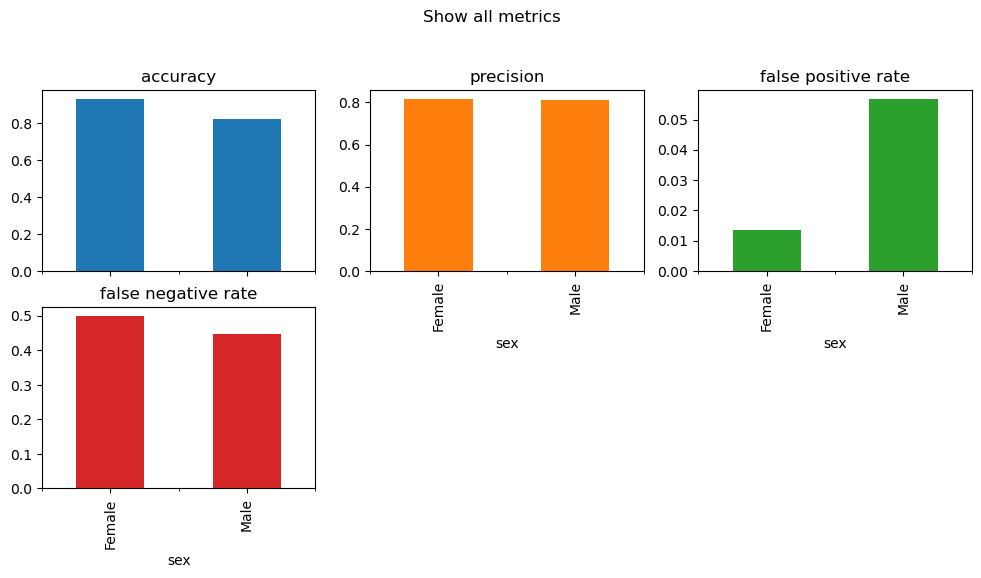

In [11]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

# Mitigating Discrimination 

## We will now learn the implementation various mitigation techniques using Fairlearn.

### Mitigating unfairness in AI and machine learning is a critical challenge that involves several strategies aimed at promoting equitable outcomes. Majorly, there are three different approaches to mitigating unfairness in AI and machine learning:

#### 1. Fair Data Pre-Processing:
   - Preprocessing algorithms transform the dataset to mitigate possible unfairness present in the data. 


#### 2. Fairness-Aware In-Processing Algorithms:
   - Incorporating fairness constraints directly into the machine learning models.
   - Adjusting the learning process to reduce bias and disparate impact.
   - Ensuring that predictions are made more equitably and do not disproportionately affect specific demographic groups.

#### 3. Post-Processing Methods:
   - Refining model predictions after they have been generated.
   - Re-ranking or re-weighting outcomes to achieve fairness.
   - Correcting any unfairness that might have been introduced during the model's training process.

### 1. Preprocessing

#### Correlation Remover
Sensitive features can be correlated with non-sensitive features in the dataset. By applying the CorrelationRemover, these correlations are projected away while details from the original data are retained as much as possible (as measured by the least-squares error).

<Axes: >

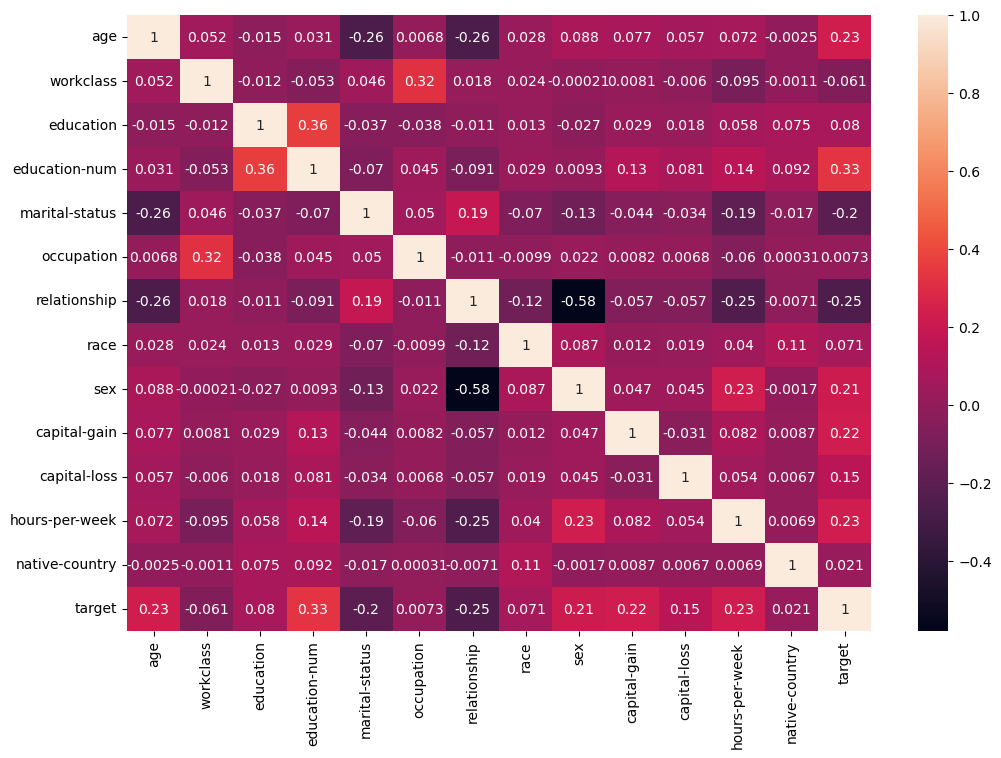

In [12]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
# Initialize LabelEncoder
label_encoders = {}
data_labenc=data_labenc.drop(columns=['fnlwgt'])
data_labenc['target']=y_true.copy() ### we will use this later to visualize the whole data

# Iterate through categorical columns and apply Label Encoding
for column in data_labenc.select_dtypes(include=['object','category']).columns:
    label_encoders[column] = LabelEncoder()
    data_labenc[column] = label_encoders[column].fit_transform(data_labenc[column].astype(str))

# Compute the correlation matrix
correlation_matrix = data_labenc.corr()
plt.subplots(figsize=(12,8))
sns.heatmap(correlation_matrix,annot=True)

In [13]:
from fairlearn.preprocessing import CorrelationRemover

In [14]:
X=data_labenc.drop(columns=['target']).copy()

In [15]:
cr = CorrelationRemover(sensitive_feature_ids=['sex'])
cr.fit(X)
X_transform = cr.transform(X)

#### The transformation removes the Protected/Sensitive attribute from the Data, and also changes the data format into Numpy arrays from Pandas DataFrame.

In [16]:
X_transform.shape

(48842, 12)

In [17]:
X.to_numpy().shape

(48842, 13)

In [18]:
cl=X.drop(columns=['sex']).columns

For our visualization it is easy to use DataFrame format. Thus, we want to revert back the format from Numpy Arrays to Pandas DataFrames.

In [19]:
X_transform=pd.DataFrame(X_transform,columns=cl)

Remember, we also need to add back the columns 'TARGET' and 'SEX' which was removed from the data, becuase we are mainly intererested to see if there is some high indirect correlation still exists in the data from Sex to Target class.  

In [20]:
X_transform['sex']=data_labenc['sex'].copy()
X_transform['target']=data_labenc['target'].copy()

<Axes: >

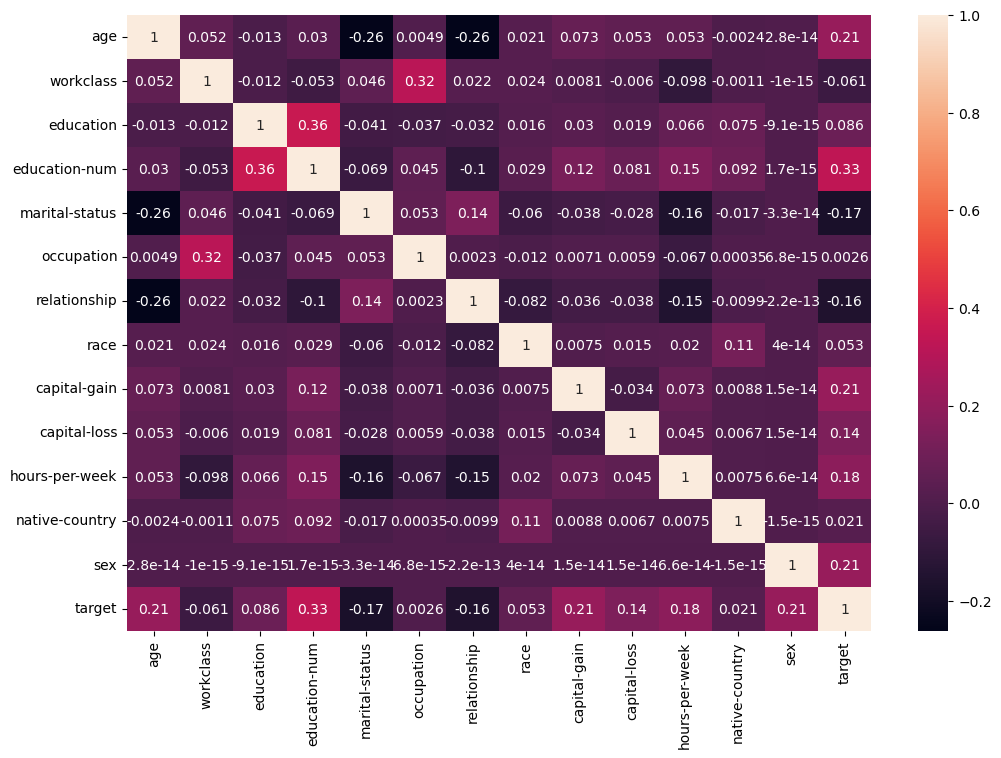

In [21]:
correlation_matrix = X_transform.corr()
plt.subplots(figsize=(12,8))
sns.heatmap(correlation_matrix,annot=True)

Our visualization is done. Time to again remove the attributes Sex and Target from the data to prepare it for model training.

In [22]:
X=X_transform.drop(columns=['sex','target']).copy()

In [23]:
fairclassifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=8)
fairclassifier.fit(X, y_true)
y_pred = fairclassifier.predict(X)

array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: xlabel='sex'>, <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

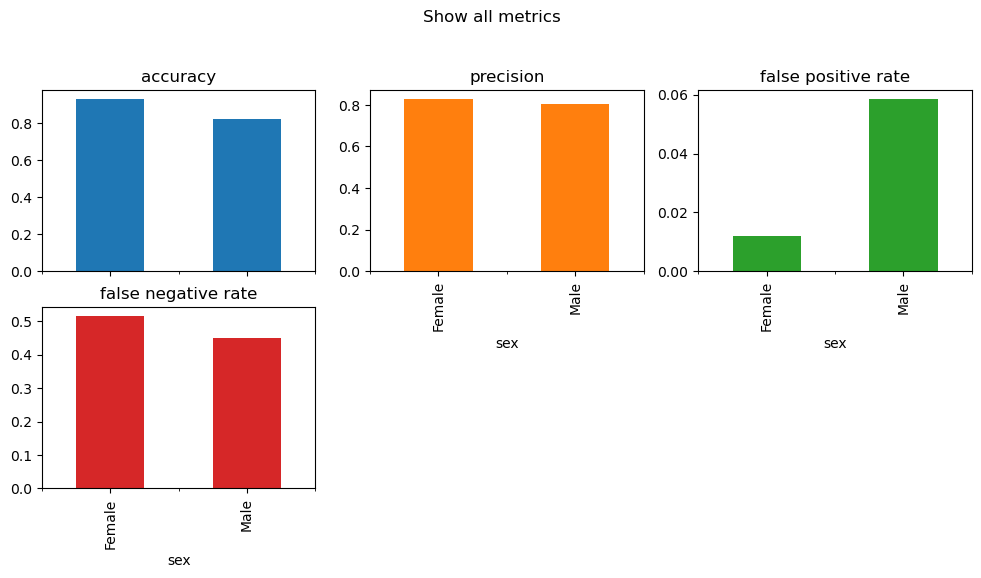

In [24]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

### 2. In-Preprocessing

This module mainly contains algorithms implementing the reductions approach to disparity mitigation. In general this is a much powerful approach as it takes the fairness correction actions directly within the learning process itself. 

In this approach, disparity constraints are cast as Lagrange multipliers, which cause the reweighting and 
relabelling of the input data. This reduces the problem back to standard machine learning training. 

There are also some adverserial learning methods provided in the Fairlearn framework which runs Tensorflow/Pytorch at the backend, but we will talk about it some other day. 

In [25]:
from fairlearn.reductions import ExponentiatedGradient, TruePositiveRateParity

In [26]:
from IPython.display import Image

We saw that the main problem previously was in False Negative Rate (FNR) Parity, but here we import some library called  TruePositiveRateParity. Why???

Because, first of all only the library for True Pos Rate (TPR) constraints are available in the Framework. :D
But, in principle equating TPR parity is same as equating FNR parity.

#### TPR= 1- FNR

<img src="https://miro.medium.com/v2/resize:fit:356/0*SgWaJnrBJsi8_LX8.png" alt="Confusion Matrix" style="width:300px;height:200px" />

<img src="https://miro.medium.com/v2/resize:fit:676/1*k6qWU7kXeCfk2KK2y3Cysg.png" alt="Definitions of TPR, FNR, TNR, and FPR" style="width:300px;height:200px" />


Thus, effectively we can reduce the gap (parity) between FNR of different groups (male, female, etc.) by minimizing the TPR gap between them and vice versa. 

In [27]:
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1

In [28]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=8)
expgrad = ExponentiatedGradient(classifier, constraints=TruePositiveRateParity(),
                                        eps=0.1)
expgrad.fit(X, y_true, sensitive_features=sex)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.TruePositiveRateParity object at 0x138b91bd0>,
                      eps=0.1,
                      estimator=DecisionTreeClassifier(max_depth=8,
                                                       min_samples_leaf=5),
                      nu=0.0007831174208816085)

In [29]:
y_pred=expgrad.predict(X)

array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: xlabel='sex'>, <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

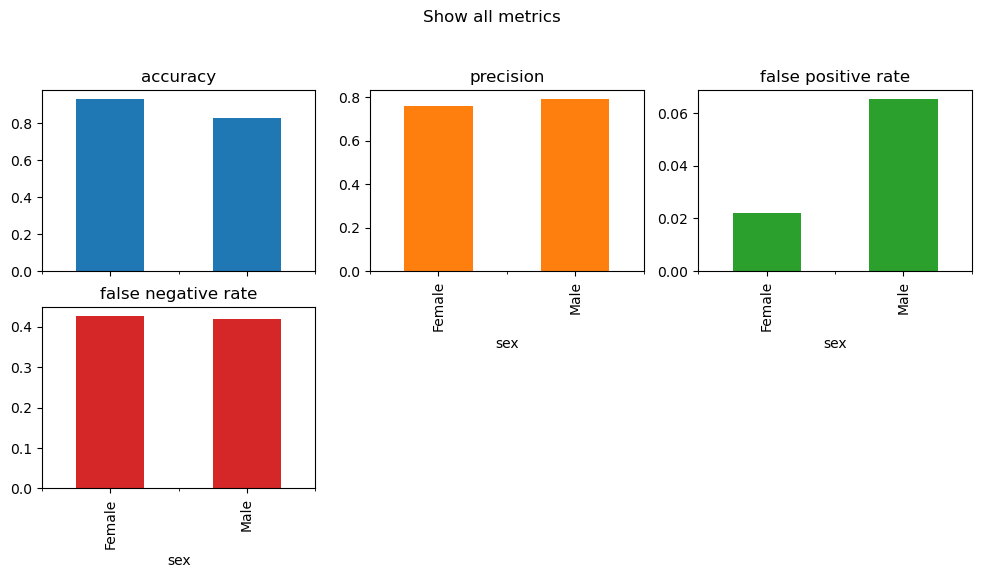

In [30]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [31]:
X=X_transform.drop(columns=['sex','target']).copy()
expgrad = ExponentiatedGradient(classifier, constraints=TruePositiveRateParity(),
                                        eps=0.1)
expgrad.fit(X, y_true, sensitive_features=sex)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.TruePositiveRateParity object at 0x13bc021d0>,
                      eps=0.1,
                      estimator=DecisionTreeClassifier(max_depth=8,
                                                       min_samples_leaf=5),
                      nu=0.0007879176129785409)

array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: xlabel='sex'>, <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

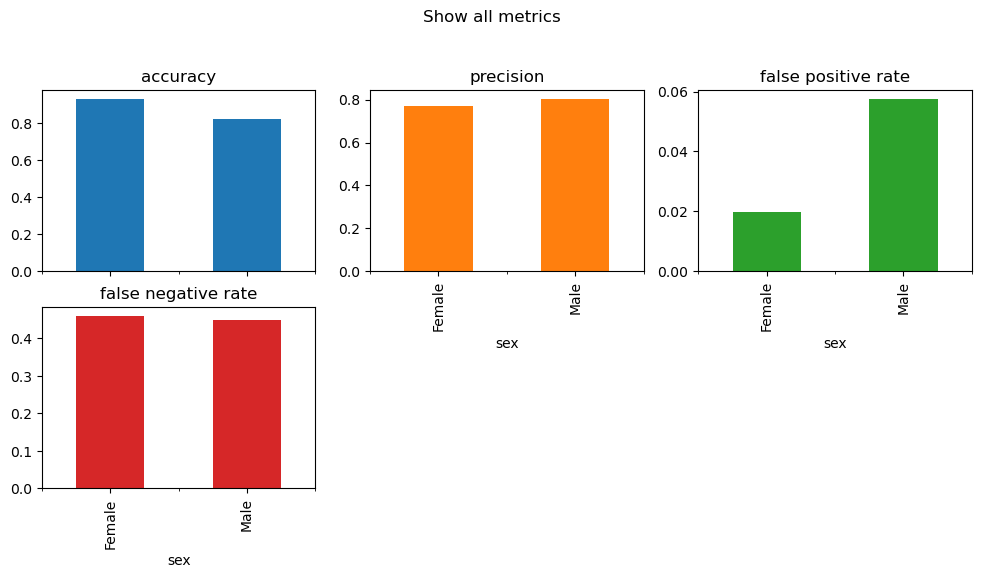

In [32]:
y_pred=expgrad.predict(X)
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [33]:
from fairlearn.reductions import EqualizedOdds

In [34]:
X=X_transform.drop(columns=['sex','target']).copy()
expgrad = ExponentiatedGradient(classifier, constraints=EqualizedOdds(),
                                        eps=0.1)
expgrad.fit(X, y_true, sensitive_features=sex)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x13c83ea90>,
                      eps=0.1,
                      estimator=DecisionTreeClassifier(max_depth=8,
                                                       min_samples_leaf=5),
                      nu=0.0007879176129785402)

array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: xlabel='sex'>, <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

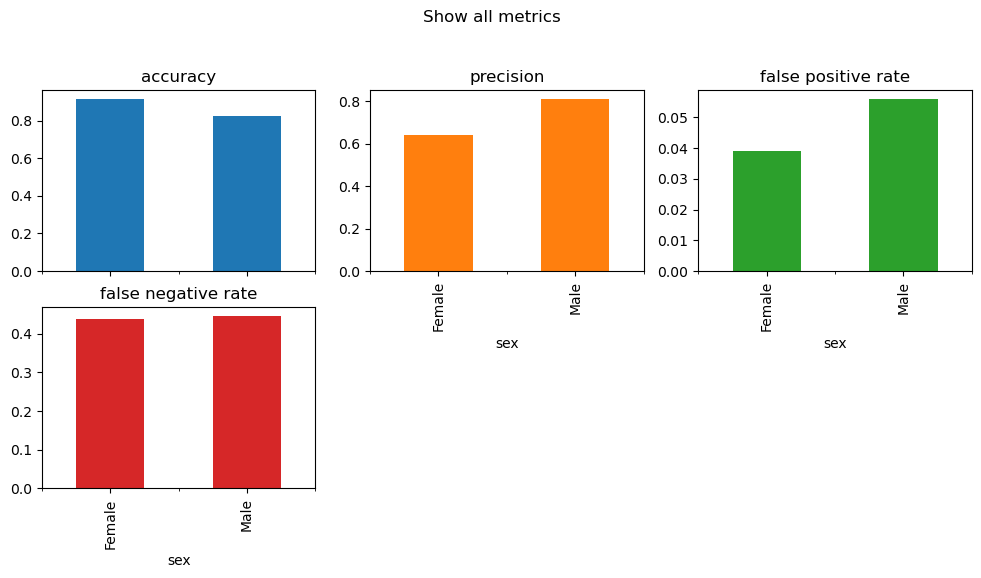

In [35]:
y_pred=expgrad.predict(X)
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

### 3. Post-Processing

Post-processing techniques come into play after a model has been trained and are particularly useful when modifying the training data or model architecture is impractical. Several well-known post-processing methods are employed to enhance fairness:

- Threshold Adjustment: This method involves fine-tuning the decision threshold of a model.
- Calibration: Calibration techniques aim to adjust the model's output probabilities. 
- Reject Option Classification: This technique introduces a "reject" option for the model when it's uncertain about a decision.


In [36]:
from fairlearn.postprocessing import ThresholdOptimizer,plot_threshold_optimizer


In [37]:
X = pd.get_dummies(data.data)

In [38]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=8)
classifier.fit(X,y_true)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=5)

In [45]:
adjusted_predictor = ThresholdOptimizer(estimator=classifier,
                                                    constraints='equalized_odds')
adjusted_predictor.fit(X, y_true, sensitive_features=sex)

/Users/arjunroy/anaconda3/lib/python3.11/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:292: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


ThresholdOptimizer(constraints='equalized_odds',
                   estimator=DecisionTreeClassifier(max_depth=8,
                                                    min_samples_leaf=5))

array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: xlabel='sex'>, <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

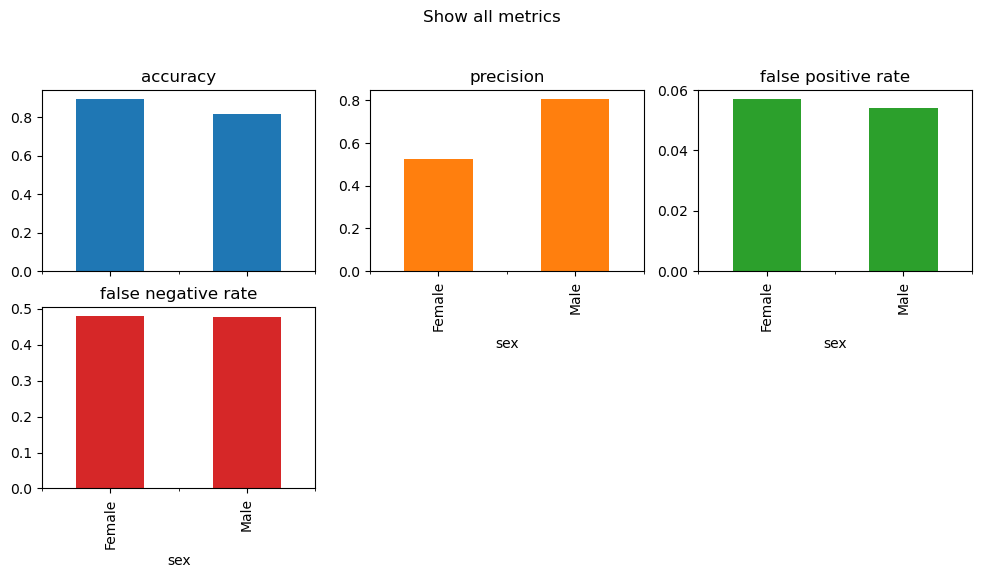

In [47]:
y_pred=adjusted_predictor.predict(X,sensitive_features=sex)
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

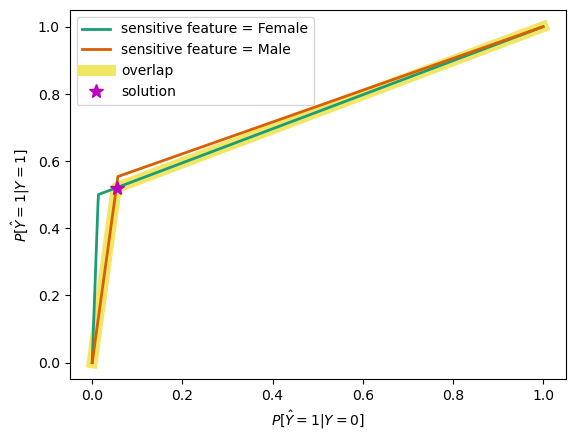

In [48]:
plot_threshold_optimizer(adjusted_predictor)